# get file paths to trian, test, and val directories.

In [26]:
import pathlib
import os

path = pathlib.Path('C:\\Users\\hunte\\OneDrive\\Documents\\Coding Projects\\Machine Learning Learning\\Vegetable Image Classification\\Vegetable Images')
    
train_test_val_folders = os.listdir(path)
data_path = []

for set_folder in train_test_val_folders:
    set_ = os.path.join(path, set_folder)
    data_path.append(set_)


# Load in test, val, and train data with ImageDataGenerator.

In [36]:
from keras.preprocessing.image import ImageDataGenerator


train_gen=ImageDataGenerator(rescale=1./255,validation_split=0.2)


train_data=train_gen.flow_from_directory(data_path[1],
                                         target_size=(224,224),
                                         batch_size=32,
                                         class_mode='categorical',
                                         shuffle=True)

test_data=train_gen.flow_from_directory(data_path[0],
                                        target_size=(224,224),
                                        batch_size=1,
                                        shuffle=False)   

val_data=train_gen.flow_from_directory(data_path[2],
                                        target_size=(224,224),
                                        batch_size=1,
                                        shuffle=False)   

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [37]:
test_data[0][0][0].shape  #indices refer to [batch number][image index][rgb channels]

(224, 224, 3)

# Visualize images

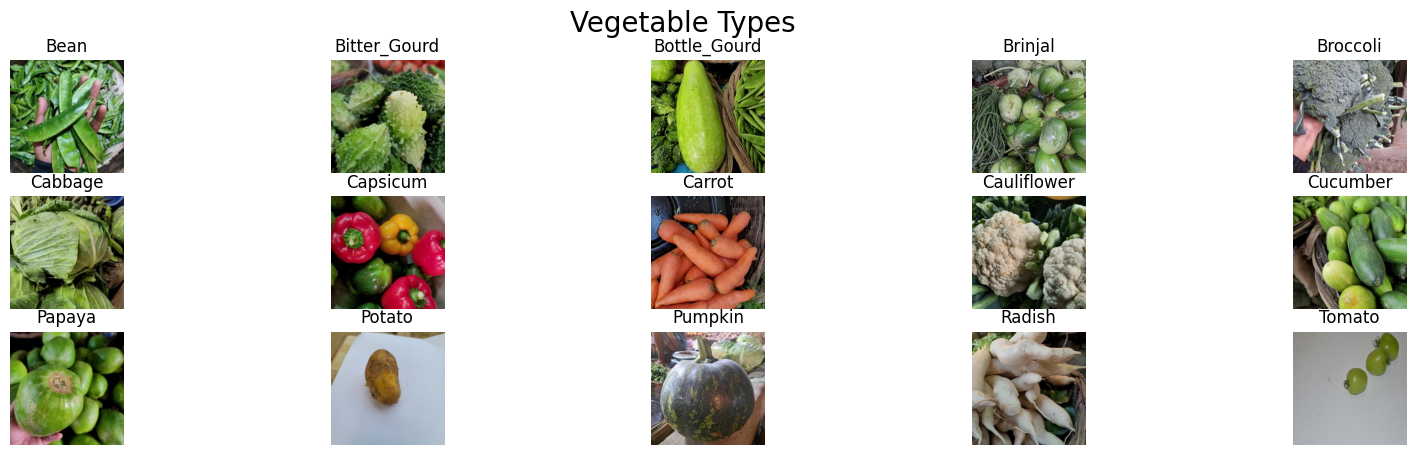

In [38]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(20,5))
fig.suptitle('Vegetable Types', color='black', fontsize=20)

class_indices = test_data.class_indices

class_count = 0  # Variable to keep track of the number of displayed images

for class_name, label in class_indices.items():
    # Find the first image of the current class
    for i in range(len(test_data)):
        images, labels = test_data[i]
        class_labels = labels.argmax(axis=1)  # Convert one-hot encoded labels to class labels

        # Find the index of the first image belonging to the current class
        image_index = np.where(class_labels == label)[0]

        if len(image_index) > 0:
            image = images[image_index[0]]
            
            # Display the image
            ax[class_count // 5][class_count % 5].imshow(image)
            ax[class_count // 5][class_count % 5].set_title(class_name)
            ax[class_count // 5][class_count % 5].axis('off')
            
            class_count += 1

            break

    # Break the loop if we have displayed images from each class
    if class_count >= 15:
        break

plt.show()


# Initial Model

In [57]:
from tensorflow import keras

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[224, 224, 3]),
    
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2,2)),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(units=40, activation="relu"),
    
    keras.layers.Dense(15, activation="softmax")
])

model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 26, 26, 96)       0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 64896)             0         
                                                                 
 dense_26 (Dense)            (None, 40)                2595880   
                                                                 
 dense_27 (Dense)            (None, 15)                615       
                                                                 
Total params: 2,631,439
Trainable params: 2,631,439
Non-trainable params: 0
____________________________________________

In [58]:
model.compile(loss="categorical_crossentropy",
             optimizer= "adam",
             metrics=['accuracy'])

In [59]:
from keras.callbacks import EarlyStopping

history = model.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    epochs=200,
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size,
    callbacks=EarlyStopping(patience=10)

)

Epoch 1/200
468/468 [==============================] - 66s 140ms/step - loss: 1.7270 - accuracy: 0.4214 - val_loss: 1.2700 - val_accuracy: 0.5860
Epoch 2/200
468/468 [==============================] - 65s 139ms/step - loss: 0.8928 - accuracy: 0.7088 - val_loss: 0.7875 - val_accuracy: 0.7570
Epoch 3/200
468/468 [==============================] - 66s 142ms/step - loss: 0.5329 - accuracy: 0.8318 - val_loss: 0.6623 - val_accuracy: 0.8113
Epoch 4/200
468/468 [==============================] - 68s 145ms/step - loss: 0.3532 - accuracy: 0.8916 - val_loss: 0.7986 - val_accuracy: 0.7653
Epoch 5/200
468/468 [==============================] - 71s 151ms/step - loss: 0.2162 - accuracy: 0.9343 - val_loss: 0.6907 - val_accuracy: 0.8270
Epoch 6/200
468/468 [==============================] - 72s 154ms/step - loss: 0.1385 - accuracy: 0.9599 - val_loss: 0.7882 - val_accuracy: 0.8250
Epoch 7/200
468/468 [==============================] - 69s 148ms/step - loss: 0.1158 - accuracy: 0.9663 - val_loss: 0.7072 -

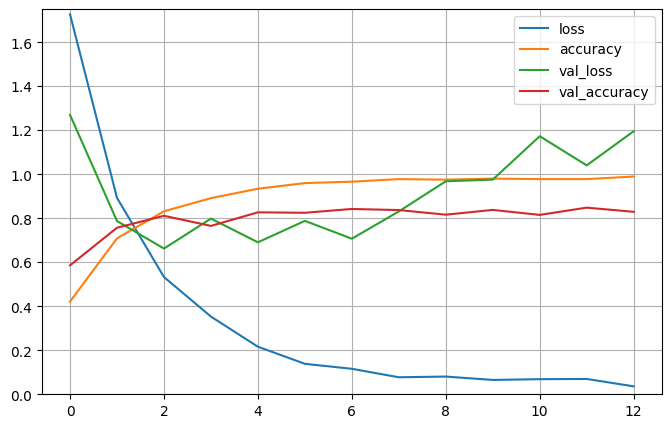

In [62]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.75)
plt.show()

In [70]:
model.evaluate(test_data)

3000/3000 [==============================] - 14s 5ms/step - loss: 1.0853 - accuracy: 0.8247


[1.0852875709533691, 0.8246666789054871]

# Revision 1

Inititial model is overfitting. I will add regularization in the form of dropout.

In [66]:
model_2 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[224, 224, 3]),
    
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2,2)),
    keras.layers.Dropout(0.5),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(units=40, activation="relu"),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(15, activation="softmax")
])

model_2.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 26, 26, 96)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 26, 26, 96)        0         
                                                                 
 flatten_10 (Flatten)        (None, 64896)             0         
                                                                 
 dense_30 (Dense)            (None, 40)                2595880   
                                                                 
 dropout_13 (Dropout)        (None, 40)                0         
                                                     

In [67]:
model_2.compile(loss="categorical_crossentropy",
             optimizer= "adam",
             metrics=['accuracy'])

In [68]:
from keras.callbacks import EarlyStopping

history = model_2.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    epochs=200,
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size,
    callbacks=EarlyStopping(patience=10)

)

Epoch 1/200
468/468 [==============================] - 71s 150ms/step - loss: 2.1844 - accuracy: 0.2549 - val_loss: 1.5577 - val_accuracy: 0.5137
Epoch 2/200
468/468 [==============================] - 76s 163ms/step - loss: 1.5134 - accuracy: 0.4947 - val_loss: 1.0833 - val_accuracy: 0.6547
Epoch 3/200
468/468 [==============================] - 83s 177ms/step - loss: 1.2619 - accuracy: 0.5783 - val_loss: 0.8407 - val_accuracy: 0.7543
Epoch 4/200
468/468 [==============================] - 87s 185ms/step - loss: 1.1015 - accuracy: 0.6253 - val_loss: 0.7278 - val_accuracy: 0.7760
Epoch 5/200
468/468 [==============================] - 82s 175ms/step - loss: 1.0101 - accuracy: 0.6565 - val_loss: 0.7121 - val_accuracy: 0.7850
Epoch 6/200
468/468 [==============================] - 80s 170ms/step - loss: 0.9303 - accuracy: 0.6828 - val_loss: 0.6822 - val_accuracy: 0.7953
Epoch 7/200
468/468 [==============================] - 77s 165ms/step - loss: 0.9037 - accuracy: 0.6933 - val_loss: 0.7061 -

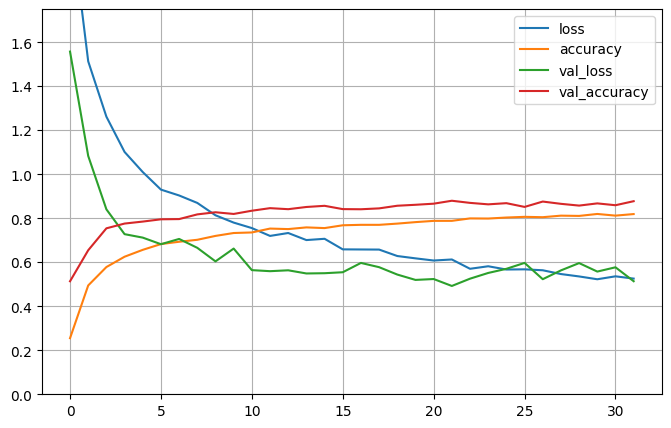

In [69]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.75)
plt.show()

In [72]:
model_2.evaluate(test_data)

3000/3000 [==============================] - 14s 5ms/step - loss: 0.4843 - accuracy: 0.8697


[0.4843173027038574, 0.8696666955947876]

# Revision 2

Regularization has improved performance from 82.4% acc to 86.9%, but still not good enough. I'm going to reduce the kernel size of the convolutional layer while also adding another layer.This will reduce the parameter load significantly from 2.6 mil to 43 thousand. This will reduce computational load and increase receptive field.

In [73]:
model_3 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[224, 224, 3]),
    
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(4,4), padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2,2)),
    keras.layers.Dropout(0.5),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(4,4), padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2,2)),
    keras.layers.Dropout(0.5),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(units=40, activation="relu"),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(15, activation="softmax")
])

model_3.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 56, 56, 32)        896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 27, 27, 32)       0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 27, 27, 32)        0         
                                                                 
 conv2d_29 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 3, 3, 64)         0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 3, 3, 64)        

In [74]:
model_3.compile(loss="categorical_crossentropy",
             optimizer= "adam",
             metrics=['accuracy'])

In [75]:
history = model_3.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    epochs=200,
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size,
    callbacks=EarlyStopping(patience=10)

)

Epoch 1/200
468/468 [==============================] - 28s 58ms/step - loss: 2.2842 - accuracy: 0.2062 - val_loss: 1.7248 - val_accuracy: 0.4527
Epoch 2/200
468/468 [==============================] - 34s 73ms/step - loss: 1.7297 - accuracy: 0.3952 - val_loss: 1.4820 - val_accuracy: 0.5047
Epoch 3/200
468/468 [==============================] - 33s 70ms/step - loss: 1.4942 - accuracy: 0.4741 - val_loss: 1.1301 - val_accuracy: 0.6360
Epoch 4/200
468/468 [==============================] - 34s 73ms/step - loss: 1.3550 - accuracy: 0.5281 - val_loss: 1.0594 - val_accuracy: 0.6687
Epoch 5/200
468/468 [==============================] - 35s 74ms/step - loss: 1.2347 - accuracy: 0.5630 - val_loss: 0.8641 - val_accuracy: 0.7317
Epoch 6/200
468/468 [==============================] - 33s 70ms/step - loss: 1.1452 - accuracy: 0.6034 - val_loss: 0.8224 - val_accuracy: 0.7693
Epoch 7/200
468/468 [==============================] - 33s 71ms/step - loss: 1.0899 - accuracy: 0.6205 - val_loss: 0.7312 - val_ac

468/468 [==============================] - 34s 73ms/step - loss: 0.5484 - accuracy: 0.8184 - val_loss: 0.2413 - val_accuracy: 0.9383
Epoch 58/200
468/468 [==============================] - 32s 68ms/step - loss: 0.5571 - accuracy: 0.8132 - val_loss: 0.2258 - val_accuracy: 0.9367
Epoch 59/200
468/468 [==============================] - 31s 67ms/step - loss: 0.5477 - accuracy: 0.8191 - val_loss: 0.2205 - val_accuracy: 0.9420
Epoch 60/200
468/468 [==============================] - 32s 68ms/step - loss: 0.5521 - accuracy: 0.8206 - val_loss: 0.2043 - val_accuracy: 0.9467
Epoch 61/200
468/468 [==============================] - 33s 71ms/step - loss: 0.5456 - accuracy: 0.8202 - val_loss: 0.2015 - val_accuracy: 0.9450
Epoch 62/200
468/468 [==============================] - 33s 71ms/step - loss: 0.5507 - accuracy: 0.8212 - val_loss: 0.2063 - val_accuracy: 0.9377
Epoch 63/200
468/468 [==============================] - 32s 69ms/step - loss: 0.5399 - accuracy: 0.8234 - val_loss: 0.2250 - val_accuracy

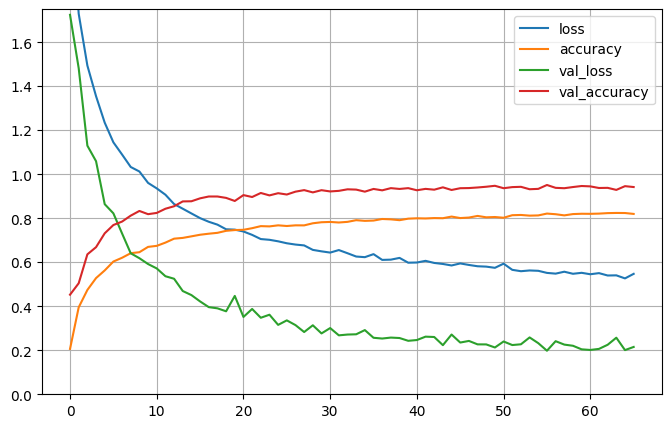

In [76]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.75)
plt.show()

In [78]:
model_3.evaluate(test_data)

3000/3000 [==============================] - 7s 2ms/step - loss: 0.2294 - accuracy: 0.9390


[0.22936509549617767, 0.9390000104904175]

# Revision 3

86.9% --> 93.9% Nice. Let's see if we can squeeze out a few more percentage points. I have increased the number of feature maps per convolutional layer.

In [91]:
model_4 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[224, 224, 3]),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(4,4), padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2,2)),
    keras.layers.Dropout(0.5),
    
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(4,4), padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2,2)),
    keras.layers.Dropout(0.5),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(units=40, activation="relu"),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(15, activation="softmax")
])

model_4.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 56, 56, 64)        1792      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 27, 27, 64)       0         
 g2D)                                                            
                                                                 
 dropout_34 (Dropout)        (None, 27, 27, 64)        0         
                                                                 
 conv2d_48 (Conv2D)          (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 3, 3, 128)        0         
 g2D)                                                            
                                                                 
 dropout_35 (Dropout)        (None, 3, 3, 128)       

In [92]:
model_4.compile(loss="categorical_crossentropy",
             optimizer= "adam",
             metrics=['accuracy'])

In [93]:
history = model_4.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    epochs=200,
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size,
    callbacks=EarlyStopping(patience=10)

)

Epoch 1/200
468/468 [==============================] - 38s 80ms/step - loss: 2.2896 - accuracy: 0.2145 - val_loss: 1.6795 - val_accuracy: 0.4747
Epoch 2/200
468/468 [==============================] - 36s 78ms/step - loss: 1.7261 - accuracy: 0.3966 - val_loss: 1.2219 - val_accuracy: 0.6307
Epoch 3/200
468/468 [==============================] - 36s 76ms/step - loss: 1.4475 - accuracy: 0.4895 - val_loss: 1.0186 - val_accuracy: 0.7037
Epoch 4/200
468/468 [==============================] - 37s 78ms/step - loss: 1.2750 - accuracy: 0.5454 - val_loss: 0.9724 - val_accuracy: 0.6900
Epoch 5/200
468/468 [==============================] - 38s 81ms/step - loss: 1.1711 - accuracy: 0.5837 - val_loss: 0.7196 - val_accuracy: 0.7800
Epoch 6/200
468/468 [==============================] - 39s 83ms/step - loss: 1.0822 - accuracy: 0.6093 - val_loss: 0.6633 - val_accuracy: 0.8197
Epoch 7/200
468/468 [==============================] - 39s 84ms/step - loss: 1.0145 - accuracy: 0.6402 - val_loss: 0.5841 - val_ac

468/468 [==============================] - 44s 93ms/step - loss: 0.4346 - accuracy: 0.8593 - val_loss: 0.1379 - val_accuracy: 0.9600
Epoch 58/200
468/468 [==============================] - 40s 86ms/step - loss: 0.4085 - accuracy: 0.8641 - val_loss: 0.1516 - val_accuracy: 0.9570
Epoch 59/200
468/468 [==============================] - 42s 90ms/step - loss: 0.4102 - accuracy: 0.8630 - val_loss: 0.1559 - val_accuracy: 0.9613


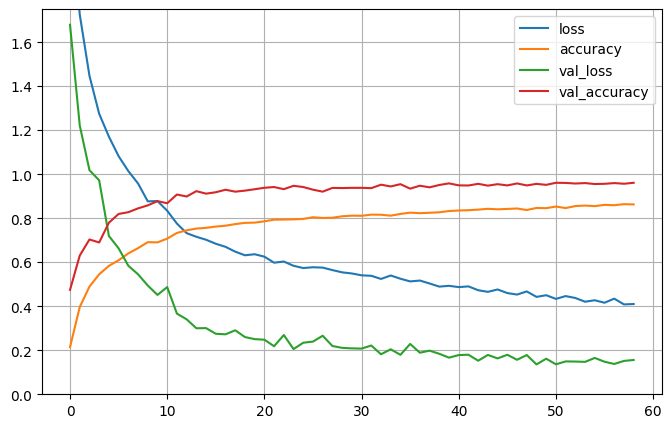

In [94]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.75)
plt.show()

In [95]:
model_4.evaluate(test_data)

3000/3000 [==============================] - 8s 3ms/step - loss: 0.1458 - accuracy: 0.9620


[0.14575520157814026, 0.9620000123977661]

93.9% --> 96.2%

# Revision 4

let's see if we can push the number of feature maps even further

In [96]:
model_5 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[224, 224, 3]),
    
    keras.layers.Conv2D(filters=96, kernel_size=(3,3), strides=(4,4), padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2,2)),
    keras.layers.Dropout(0.5),
    
    keras.layers.Conv2D(filters=192, kernel_size=(3,3), strides=(4,4), padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2,2)),
    keras.layers.Dropout(0.5),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(units=40, activation="relu"),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(15, activation="softmax")
])

model_5.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 56, 56, 96)        2688      
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 dropout_37 (Dropout)        (None, 27, 27, 96)        0         
                                                                 
 conv2d_50 (Conv2D)          (None, 7, 7, 192)         166080    
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 3, 3, 192)        0         
 g2D)                                                            
                                                                 
 dropout_38 (Dropout)        (None, 3, 3, 192)       

In [97]:
model_5.compile(loss="categorical_crossentropy",
             optimizer= "adam",
             metrics=['accuracy'])

In [98]:
history = model_5.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    epochs=200,
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size,
    callbacks=EarlyStopping(patience=10)

)

Epoch 1/200
468/468 [==============================] - 44s 93ms/step - loss: 2.3369 - accuracy: 0.2068 - val_loss: 1.6115 - val_accuracy: 0.4873
Epoch 2/200
468/468 [==============================] - 44s 93ms/step - loss: 1.6578 - accuracy: 0.4203 - val_loss: 1.1899 - val_accuracy: 0.6573
Epoch 3/200
468/468 [==============================] - 42s 90ms/step - loss: 1.3699 - accuracy: 0.5210 - val_loss: 0.8480 - val_accuracy: 0.7563
Epoch 4/200
468/468 [==============================] - 44s 94ms/step - loss: 1.1809 - accuracy: 0.5863 - val_loss: 0.7548 - val_accuracy: 0.7760
Epoch 5/200
468/468 [==============================] - 42s 91ms/step - loss: 1.0694 - accuracy: 0.6256 - val_loss: 0.6139 - val_accuracy: 0.8393
Epoch 6/200
468/468 [==============================] - 43s 92ms/step - loss: 0.9561 - accuracy: 0.6629 - val_loss: 0.5676 - val_accuracy: 0.8573
Epoch 7/200
468/468 [==============================] - 41s 89ms/step - loss: 0.8950 - accuracy: 0.6891 - val_loss: 0.4508 - val_ac

468/468 [==============================] - 43s 93ms/step - loss: 0.3830 - accuracy: 0.8725 - val_loss: 0.1330 - val_accuracy: 0.9627
Epoch 58/200
468/468 [==============================] - 44s 94ms/step - loss: 0.3975 - accuracy: 0.8683 - val_loss: 0.1311 - val_accuracy: 0.9653
Epoch 59/200
468/468 [==============================] - 44s 94ms/step - loss: 0.3788 - accuracy: 0.8747 - val_loss: 0.1352 - val_accuracy: 0.9630
Epoch 60/200
468/468 [==============================] - 47s 100ms/step - loss: 0.3777 - accuracy: 0.8773 - val_loss: 0.1487 - val_accuracy: 0.9520
Epoch 61/200
468/468 [==============================] - 46s 97ms/step - loss: 0.3682 - accuracy: 0.8754 - val_loss: 0.1270 - val_accuracy: 0.9643
Epoch 62/200
468/468 [==============================] - 45s 97ms/step - loss: 0.3633 - accuracy: 0.8787 - val_loss: 0.1350 - val_accuracy: 0.9600
Epoch 63/200
468/468 [==============================] - 45s 97ms/step - loss: 0.3775 - accuracy: 0.8744 - val_loss: 0.1273 - val_accurac

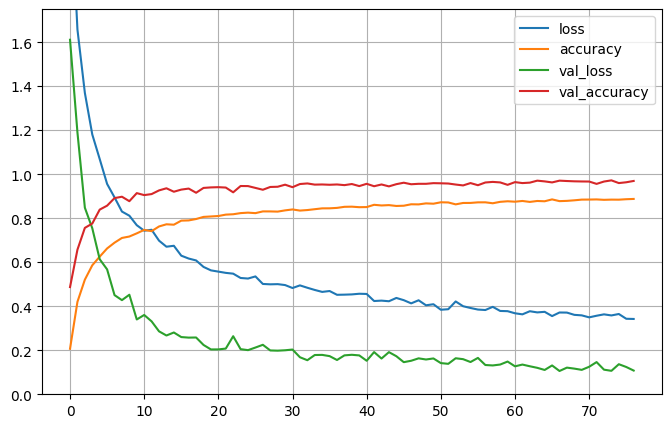

In [99]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.75)
plt.show()

In [100]:
model_5.evaluate(test_data)

3000/3000 [==============================] - 17s 6ms/step - loss: 0.1037 - accuracy: 0.9747


[0.10370354354381561, 0.9746666550636292]

96.2% --> 97.46%